In [25]:
# Importing machine learning classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

# Importing preprocessing tools
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

# Importing evaluation metrics
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Importing model selection utilities
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# Importing libraries for data visualization and manipulation
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Importing time for performance tracking
import time

In [27]:
df = pd.read_csv("coin_dataset.csv")  # Read in the coin dataset
label_encoder = LabelEncoder()  # For encoding categorical variables
mms = MinMaxScaler()  # MinMaxScaler for scaling numerical features
scaler = StandardScaler()  # StandardScaler for standardizing numerical features

# Parameters for cross-validation and training
test_size = 0.3  # Test set proportion
folds = 10  # Number of folds for cross-validation
iterations = 10  # Number of iterations for model training
cores = -1  # Use all available cores
verbose = 1  # Print progress during grid search
random_state = None  # Optional random state for reproducibility

# Lists to store model scores
knn_score_list = []
dt_score_list = []
rf_score_list = []
perceptron_score_list = []
lr_score_list = []
predictions = [] # List to store final predictions

# Labels for confusion matrix
confusion_labels = ['Not Legal Tender', 'Legal Tender']
# Columns to scale
cols_to_scale = ['diameter', 'thickness', 'weight']
# Categorical features to encode
categorical_features = ["edge", "main_metal"]

# Hyperparameter grid for bagging classifier
param_grid_bag = {'n_estimators': [5, 10, 25, 50, 100, 200, 400],'max_samples': [0.5, 0.75, 1.0],'bootstrap': [True, False],'bootstrap_features': [True, False]}
param_dist_bag = {'n_estimators': [5, 10, 25, 50, 100, 200, 400],'max_samples': [0.5, 0.75, 1.0],'bootstrap': [True, False],'bootstrap_features': [True, False]}

# Hyperparameter grid for K-Nearest Neighbors classifier
param_grid_knn = {'n_neighbors': [3, 5, 7, 9, 11],'weights': ['uniform', 'distance'],'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],'leaf_size': [5, 15, 30, 50, 75],'p': [1, 2]}
param_dist_knn = {'n_neighbors': [3, 5, 7, 9, 11],'weights': ['uniform', 'distance'],'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],'leaf_size': [5, 15, 30, 50, 75],'p': [1, 2]}

# Hyperparameter grid for Decision Tree classifier
param_grid_dt = {'criterion': ['gini', 'entropy'],'max_depth': [5, 10, 20, 40, None],'min_samples_split': [2, 5, 10, 20],'min_samples_leaf': [1, 2, 5, 10],'max_features': [None, 'sqrt', 'log2'],'max_leaf_nodes': [None, 10, 50, 100],'splitter': ['best', 'random'],'class_weight': [None, 'balanced']}
param_dist_dt = {'criterion': ['gini', 'entropy'],'max_depth': [5, 10, 20, 40, None],'min_samples_split': [2, 5, 10, 20],'min_samples_leaf': [1, 2, 5, 10],'max_features': [None, 'sqrt', 'log2'],'max_leaf_nodes': [None, 10, 50, 100],'splitter': ['best', 'random'],'class_weight': [None, 'balanced']}

# Hyperparameter grid for Random Forest classifier
param_grid_rf = {'n_estimators': [5, 10, 25, 50, 75],'criterion': ['gini', 'entropy'],'max_depth': [5, 10, 20, None],'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 5],'max_features': [None, 'sqrt', 'log2'],'bootstrap': [True, False],'class_weight': [None, 'balanced']}
param_dist_rf = {'n_estimators': [5, 10, 25, 50, 75],'criterion': ['gini', 'entropy'],'max_depth': [5, 10, 20, None],'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 5],'max_features': [None, 'sqrt', 'log2'],'bootstrap': [True, False],'class_weight': [None, 'balanced']}

# Hyperparameter grid for Perceptron classifier
param_grid_perceptron = {'penalty': ['l2', 'l1', 'elasticnet', None],'alpha': [0.0001, 0.001, 0.01, 0.1, 1],'max_iter': [500, 1000, 2000, 3500, 5000, 7500],'tol': [1e-5, 1e-4, 1e-3, 1e-2],'eta0': [0.001, 0.01, 0.1, 1],'early_stopping': [True, False],'validation_fraction': [0.1, 0.2, 0.3],'n_iter_no_change': [5, 10, 15, 20, 25]}
param_dist_perceptron = {'penalty': ['l2', 'l1', 'elasticnet', None],'alpha': [0.0001, 0.001, 0.01, 0.1, 1],'max_iter': [500, 1000, 2000, 3500, 5000, 7500],'tol': [1e-5, 1e-4, 1e-3, 1e-2],'eta0': [0.001, 0.01, 0.1, 1],'early_stopping': [True, False],'validation_fraction': [0.1, 0.2, 0.3],'n_iter_no_change': [5, 10, 15, 20, 25]}

# Hyperparameter grid for Logistic Regression classifier
param_grid_lr = {'C': [0.01, 0.1, 1, 5, 10, 25, 50],'solver': ['newton-cg', 'lbfgs', 'saga'],'max_iter': [100, 500, 1000, 2000, 3000],'tol': [1e-4, 1e-3, 1e-2, 1e-1],'class_weight': [None, 'balanced'],'intercept_scaling': [1, 5, 10],'warm_start': [True, False]}
param_dist_lr = {'C': [0.01, 0.1, 1, 5, 10, 25, 50],'solver': ['newton-cg', 'lbfgs', 'saga'],'max_iter': [100, 500, 1000, 2000, 3000],'tol': [1e-4, 1e-3, 1e-2, 1e-1],'class_weight': [None, 'balanced'],'intercept_scaling': [1, 5, 10],'warm_start': [True, False]}

diameter min: 14.89
diameter max: 38.33
diameter mean: 23.345111111111116

thickness min: 0.71
thickness max: 2.98
thickness mean: 1.7000277777777777

weight min: 0.457
weight max: 26.741
weight mean: 6.046155555555556

edge
reeded       177
plain        163
lettered      19
decorated      1
Name: count, dtype: int64

main_metal
copper       233
silver        63
steel         16
nickel        12
zinc          10
manganese     10
aluminum       9
iron           7
Name: count, dtype: int64

magnetism
0    310
1     50
Name: count, dtype: int64

legal_us_tender
1    180
0    180
Name: count, dtype: int64


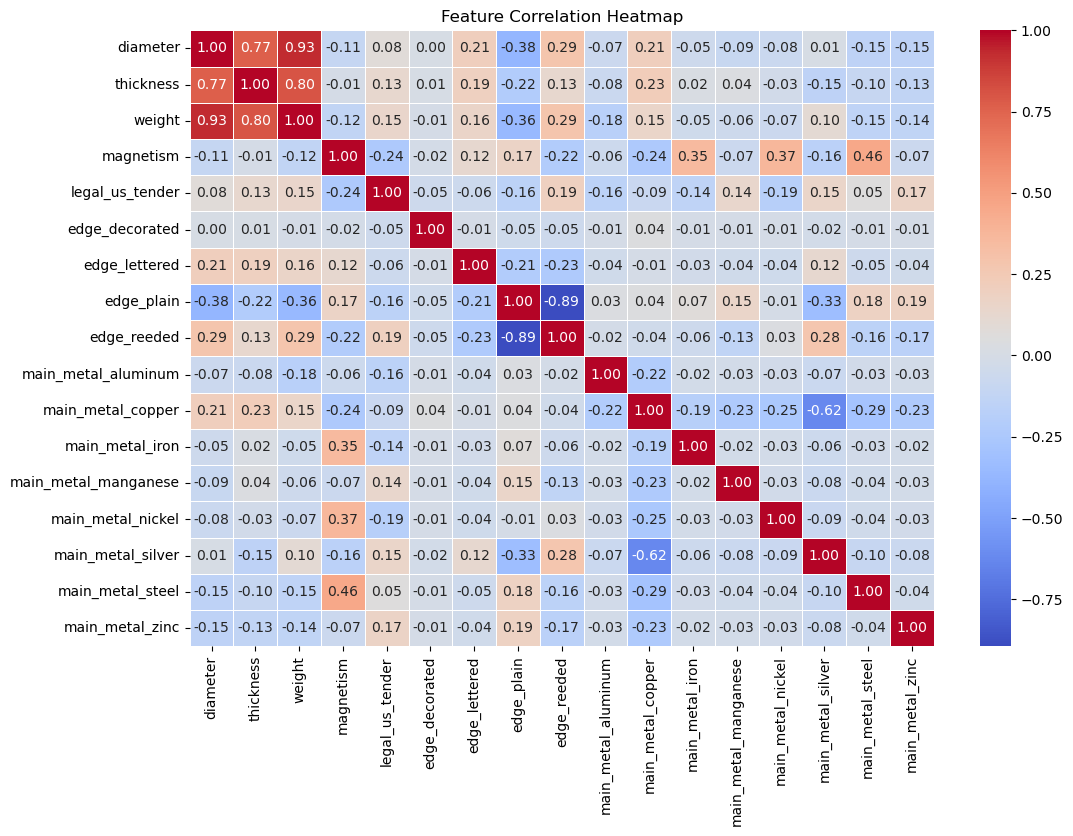


Strong Positive Correlations:
       Feature 1          Feature 2  Correlation
1       diameter             weight     0.930804
16     thickness             weight     0.804688
0       diameter          thickness     0.766446
56     magnetism   main_metal_steel     0.459051
54     magnetism  main_metal_nickel     0.372885
52     magnetism    main_metal_iron     0.350637
7       diameter        edge_reeded     0.287281
36        weight        edge_reeded     0.286180
105  edge_reeded  main_metal_silver     0.278206
24     thickness  main_metal_copper     0.227050
9       diameter  main_metal_copper     0.214223
5       diameter      edge_lettered     0.208720

Strong Negative Correlations:
               Feature 1             Feature 2  Correlation
91            edge_plain           edge_reeded    -0.894585
118    main_metal_copper     main_metal_silver    -0.623833
6               diameter            edge_plain    -0.382462
35                weight            edge_plain    -0.359826
9

In [29]:
# Print summary statistics for 'diameter'
d_min_values = df['diameter'].min()
print(f"diameter min: {d_min_values}")
d_max_values = df['diameter'].max()
print(f"diameter max: {d_max_values}")
d_mean_values = df['diameter'].mean()
print(f"diameter mean: {d_mean_values}")

# Print summary statistics for 'thickness'
t_min_values = df['thickness'].min()
print(f"\nthickness min: {t_min_values}")
t_max_values = df['thickness'].max()
print(f"thickness max: {t_max_values}")
t_mean_values = df['thickness'].mean()
print(f"thickness mean: {t_mean_values}")

# Print summary statistics for 'weight'
w_min_values = df['weight'].min()
print(f"\nweight min: {w_min_values}")
w_max_values = df['weight'].max()
print(f"weight max: {w_max_values}")
w_mean_values = df['weight'].mean()
print(f"weight mean: {w_mean_values}")

# Display value counts for categorical features
edge_counts = df['edge'].value_counts()
print(f"\n{edge_counts}")

main_metal_counts = df['main_metal'].value_counts()
print(f"\n{main_metal_counts}")

magnetism_counts = df['magnetism'].value_counts()
print(f"\n{magnetism_counts}")

legal_us_tender_counts = df['legal_us_tender'].value_counts()
print(f"\n{legal_us_tender_counts}")

# Encode categorical variables
df['magnetism'] = label_encoder.fit_transform(df['magnetism'])
df['legal_us_tender'] = label_encoder.fit_transform(df['legal_us_tender'])

# One-hot encode categorical variables
df = pd.get_dummies(df, columns=categorical_features, drop_first=False)

# Create a correlation heatmap for features
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Extract upper triangle of the correlation matrix
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Extract correlation pairs and filter strong correlations
corr_pairs = upper_triangle.stack().reset_index()
corr_pairs.columns = ["Feature 1", "Feature 2", "Correlation"]

# Filter strong positive and negative correlations
strong_pos_thresh = 0.20
strong_neg_thresh = -0.20

strong_positive = corr_pairs[corr_pairs["Correlation"] > strong_pos_thresh].sort_values(by="Correlation", ascending=False)
strong_negative = corr_pairs[corr_pairs["Correlation"] < strong_neg_thresh].sort_values(by="Correlation")

# Print strong correlations
print("\nStrong Positive Correlations:")
print(strong_positive)

print("\nStrong Negative Correlations:")
print(strong_negative)

# Scale numerical features
df[cols_to_scale] = mms.fit_transform(df[cols_to_scale])

# Shuffle the dataframe
df = df.sample(frac=1, random_state=random_state).reset_index(drop=True)

# Prepare features and target variable for modeling
X = df.drop(columns=['legal_us_tender'])
y = df['legal_us_tender']

In [4]:
def KNN_ROE_classifier():
    print("\nK-Nearest Neighbor Classifier")
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)
    
    # Scale the features
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Initialize and train the KNN classifier
    knn = KNeighborsClassifier()
    start_time = time.time()
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    default_knn_score = accuracy_score(y_test,y_pred_knn)
    end_time = time.time()
    total_runtime = end_time - start_time
    knn_score_list.append(default_knn_score)
    predictions.append(y_pred_knn)
    
    print(f"KNN Runtime Using Default KNN Params: {total_runtime:.5f} seconds")
    print(f"KNN Accuracy Score Using Default KNN Params: {default_knn_score*100:.3f}%")

    # Bagging with KNN
    bag = BaggingClassifier(estimator = knn, n_jobs=cores)
    start_time = time.time()
    bag.fit(X_train, y_train)
    y_pred_bag = bag.predict(X_test)
    default_bag_default_knn_score = accuracy_score(y_test,y_pred_bag)
    end_time = time.time()
    total_runtime = end_time - start_time
    knn_score_list.append(default_bag_default_knn_score)
    predictions.append(y_pred_bag)
    
    print(f"Bag Runtime Using Default Bag Params w/ Default KNN Params: {total_runtime:.5f} seconds")
    print(f"Bag Accuracy Score Using Default Bag Params w/ Default KNN Params: {default_bag_default_knn_score*100:.3f}%")

    # Grid Search for KNN
    grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=folds, n_jobs=cores, verbose=verbose)
    start_time = time.time()
    grid_search_knn.fit(X_train, y_train)
    
    print(f"Best KNN Params According To GridSearchCV: {grid_search_knn.best_params_}")
    
    knn.set_params(**grid_search_knn.best_params_)
    knn.fit(X_train, y_train)
    y_pred_grid_search_knn = knn.predict(X_test)
    best_knn_score_grid_search = accuracy_score(y_test,y_pred_grid_search_knn)
    end_time = time.time()
    total_runtime = end_time - start_time
    knn_score_list.append(best_knn_score_grid_search)
    predictions.append(y_pred_grid_search_knn)
    
    print(f"KNN Runtime Using Best KNN Params According To GridSearchCV: {total_runtime:.5f} seconds")
    print(f"KNN Accuracy Score Using Best KNN Params According To GridSearchCV: {best_knn_score_grid_search*100:.3f}%")

    # Randomized Search for KNN
    random_search_knn = RandomizedSearchCV(estimator=knn, param_distributions=param_dist_knn, n_iter=iterations, cv=folds, n_jobs=cores, verbose=verbose)
    start_time = time.time()
    random_search_knn.fit(X_train, y_train)
    
    print(f"Best KNN Params According To RandomizedSearchCV: {random_search_knn.best_params_}")
    
    knn.set_params(**random_search_knn.best_params_)
    knn.fit(X_train, y_train)
    y_pred_random_search_knn = knn.predict(X_test)
    best_knn_score_random_search = accuracy_score(y_test,y_pred_random_search_knn)
    end_time = time.time()
    total_runtime = end_time - start_time
    knn_score_list.append(best_knn_score_random_search)
    predictions.append(y_pred_random_search_knn)
    
    print(f"KNN Runtime Using Best KNN Params According To RandomizedSearchCV: {total_runtime:.5f} seconds")
    print(f"KNN Accuracy Score Using Best KNN Params According To RandomizedSearchCV: {best_knn_score_random_search*100:.3f}%")

    # Determine which search performed better and use selected parameters
    if random_search_knn.best_score_ > grid_search_knn.best_score_:
        knn.set_params(**random_search_knn.best_params_)
        bag = BaggingClassifier(estimator = knn)

        # Grid Search for Bagging with KNN
        grid_search_bag = GridSearchCV(estimator=bag, param_grid=param_grid_bag, cv=folds, n_jobs=cores, verbose=verbose)
        start_time = time.time()
        grid_search_bag.fit(X_train, y_train)
        
        print(f"Best Bag Params Using Best KNN Params According To GridSearchCV: {grid_search_bag.best_params_}")
        
        bag.set_params(**grid_search_bag.best_params_)
        bag.fit(X_train, y_train)
        y_pred_grid_search_bag = bag.predict(X_test)
        best_bag_best_knn_grid_search = accuracy_score(y_test,y_pred_grid_search_bag)
        end_time = time.time()
        total_runtime = end_time - start_time
        knn_score_list.append(best_bag_best_knn_grid_search)
        predictions.append(y_pred_grid_search_bag)
        
        print(f"Bag Runtime Using Best Bag Params w/ Best KNN Params According To GridSearchCV: {total_runtime:.5f} seconds")
        print(f"Bag Accuracy Score Using Best Bag Params w/ Best KNN Params According To GridSearchCV: {best_bag_best_knn_grid_search*100:.3f}%")

        # Randomized Search for Bagging with KNN
        random_search_bag = RandomizedSearchCV(estimator=bag, param_distributions=param_dist_bag, n_iter=iterations, cv=folds, n_jobs=cores, verbose=verbose)
        start_time = time.time()
        random_search_bag.fit(X_train, y_train)
        
        print(f"Best Bag Params According To RandomizedSearchCV: {random_search_bag.best_params_}")
        
        bag.set_params(**random_search_bag.best_params_)
        bag.fit(X_train, y_train)
        y_pred_random_search_bag = bag.predict(X_test)
        best_bag_best_knn_random_search = accuracy_score(y_test,y_pred_random_search_bag)
        end_time = time.time()
        total_runtime = end_time - start_time
        knn_score_list.append(best_bag_best_knn_random_search)
        predictions.append(y_pred_random_search_bag)
        
        print(f"Bag Runtime Using Best Bag Params w/ Best KNN Params According To RandomizedSearchCV: {total_runtime:.5f} seconds")
        print(f"Bag Accuracy Score Using Best Bag Params w/ Best KNN Params According To RandomizedSearchCV: {best_bag_best_knn_random_search*100:.3f}%")
    else:
        knn.set_params(**grid_search_knn.best_params_)
        bag = BaggingClassifier(estimator = knn)

        # Grid Search for Bagging with KNN
        grid_search_bag = GridSearchCV(estimator=bag, param_grid=param_grid_bag, cv=folds, n_jobs=cores, verbose=verbose)
        start_time = time.time()
        grid_search_bag.fit(X_train, y_train)
        
        print(f"Best Bag Params According To GridSearchCV: {grid_search_bag.best_params_}")
        
        bag.set_params(**grid_search_bag.best_params_)
        bag.fit(X_train, y_train)
        y_pred_grid_search_bag = bag.predict(X_test)
        best_bag_best_knn_grid_search = accuracy_score(y_test,y_pred_grid_search_bag)
        end_time = time.time()
        total_runtime = end_time - start_time
        knn_score_list.append(best_bag_best_knn_grid_search)
        predictions.append(y_pred_grid_search_bag)
        
        print(f"Bag Runtime Using Best Bag Params w/ Best KNN Params According To GridSearchCV: {total_runtime:.5f} seconds")
        print(f"Bag Accuracy Score Using Best Bag Params w/ Best KNN Params According To GridSearchCV: {best_bag_best_knn_grid_search*100:.3f}%")

        # Randomized Search for Bagging with KNN
        random_search_bag = RandomizedSearchCV(estimator=bag, param_distributions=param_dist_bag, n_iter=iterations, cv=folds, n_jobs=cores, verbose=verbose)
        start_time = time.time()
        random_search_bag.fit(X_train, y_train)
        
        print(f"Best Bag Params According To RandomizedSearchCV: {random_search_bag.best_params_}")
        
        bag.set_params(**random_search_bag.best_params_)
        bag.fit(X_train, y_train)
        y_pred_random_search_bag = bag.predict(X_test)
        best_bag_best_knn_random_search = accuracy_score(y_test,y_pred_random_search_bag)
        end_time = time.time()
        total_runtime = end_time - start_time
        knn_score_list.append(best_bag_best_knn_random_search)
        predictions.append(y_pred_random_search_bag)
        
        print(f"Bag Runtime Using Best Bag Params w/ Best KNN Params According To RandomizedSearchCV: {total_runtime:.5f} seconds")
        print(f"Bag Accuracy Score Using Best Bag Params w/ Best KNN Params According To RandomizedSearchCV: {best_bag_best_knn_random_search*100:.3f}%")

    # Find the highest scoring model and plot the confusion matrix
    highest_score_id = knn_score_list.index(max(knn_score_list))
    best_predictions = predictions[highest_score_id]
    cm = confusion_matrix(y_test, best_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=confusion_labels)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix for Best K-Nearest Neighbor Classifier Prediction")
    plt.show()
    
    tn, fp, fn, tp = cm.ravel()
    print(f"False Positive (FP): {fp}")
    print(f"False Negative (FN): {fn}")
    
    predictions.clear()

In [5]:
def DT_ROE_classifier():
    print("\nDecision Tree Classifier")

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    # Initialize and train the Decision Tree classifier
    dt = DecisionTreeClassifier()
    dt_feature_importances = [] # List to store feature importances
    start_time = time.time()
    dt.fit(X_train, y_train)
    features = dt.feature_importances_
    y_pred_dt = dt.predict(X_test)
    default_dt_score = accuracy_score(y_test,y_pred_dt)
    end_time = time.time()
    total_runtime = end_time - start_time
    dt_score_list.append(default_dt_score)
    predictions.append(y_pred_dt)
    dt_feature_importances.append(features)
    
    print(f"DT Runtime Using Default DT Params: {total_runtime:.5f} seconds")
    print(f"DT Accuracy Score Using Default DT Params: {default_dt_score*100:.3f}%")

    # Bagging with DT
    bag = BaggingClassifier(estimator = dt, n_jobs=cores)
    start_time = time.time()
    bag.fit(X_train, y_train)
    features = dt.feature_importances_
    y_pred_bag = bag.predict(X_test)
    default_bag_default_dt_score = accuracy_score(y_test,y_pred_bag)
    end_time = time.time()
    total_runtime = end_time - start_time
    dt_score_list.append(default_bag_default_dt_score)
    predictions.append(y_pred_bag)
    dt_feature_importances.append(features)
    
    print(f"Bag Runtime Using Default Bag Params w/ Default DT Params: {total_runtime:.5f} seconds")
    print(f"Bag Accuracy Score Using Default Bag Params w/ Default DT Params: {default_bag_default_dt_score*100:.3f}%")

    # Grid Search for DT
    grid_search_dt = GridSearchCV(estimator=dt, param_grid=param_grid_dt, cv=folds, n_jobs=cores, verbose=verbose)
    start_time = time.time()
    grid_search_dt.fit(X_train, y_train)
    
    print(f"Best DT Params According To GridSearchCV: {grid_search_dt.best_params_}")
    
    dt.set_params(**grid_search_dt.best_params_)
    dt.fit(X_train, y_train)
    features = dt.feature_importances_
    y_pred_grid_search_dt = dt.predict(X_test)
    best_dt_score_grid_search = accuracy_score(y_test,y_pred_grid_search_dt)
    end_time = time.time()
    total_runtime = end_time - start_time
    dt_score_list.append(best_dt_score_grid_search)
    predictions.append(y_pred_grid_search_dt)
    dt_feature_importances.append(features)
    
    print(f"DT Runtime Using Best DT Params According To GridSearchCV: {total_runtime:.5f} seconds")
    print(f"DT Accuracy Score Using Best DT Params According To GridSearchCV: {best_dt_score_grid_search*100:.3f}%")

    # Randomized Search for DT
    random_search_dt = RandomizedSearchCV(estimator=dt, param_distributions=param_dist_dt, n_iter=iterations, cv=folds, n_jobs=cores, verbose=verbose)
    start_time = time.time()
    random_search_dt.fit(X_train, y_train)
    
    print(f"Best DT Params According To RandomizedSearchCV: {random_search_dt.best_params_}")
    
    dt.set_params(**random_search_dt.best_params_)
    dt.fit(X_train, y_train)
    features = dt.feature_importances_
    y_pred_random_search_dt = dt.predict(X_test)
    best_dt_score_random_search = accuracy_score(y_test,y_pred_random_search_dt)
    end_time = time.time()
    total_runtime = end_time - start_time
    dt_score_list.append(best_dt_score_random_search)
    predictions.append(y_pred_random_search_dt)
    dt_feature_importances.append(features)
    
    print(f"DT Runtime Using Best DT Params According To RandomizedSearchCV: {total_runtime:.5f} seconds")
    print(f"DT Accuracy Score Using Best DT Params According To RandomizedSearchCV: {best_dt_score_random_search*100:.3f}%")

    # Determine which search performed better and use selected parameters
    if random_search_dt.best_score_ > grid_search_dt.best_score_:
        dt.set_params(**random_search_dt.best_params_)
        bag = BaggingClassifier(estimator = dt)

        # Grid Search for Bagging with DT
        grid_search_bag = GridSearchCV(estimator=bag, param_grid=param_grid_bag, cv=folds, n_jobs=cores, verbose=verbose)
        start_time = time.time()
        grid_search_bag.fit(X_train, y_train)
        
        print(f"Best Bag Params Using Best DT Params According To GridSearchCV: {grid_search_bag.best_params_}")
        
        bag.set_params(**grid_search_bag.best_params_)
        bag.fit(X_train, y_train)
        importances = [tree.feature_importances_ for tree in bag.estimators_] # Get feature importances from each decision tree in the ensemble
        features = np.mean(importances, axis=0) # Average the feature importances across all trees in the ensemble
        y_pred_grid_search_bag = bag.predict(X_test)
        best_bag_best_dt_grid_search = accuracy_score(y_test,y_pred_grid_search_bag)
        end_time = time.time()
        total_runtime = end_time - start_time
        dt_score_list.append(best_bag_best_dt_grid_search)
        predictions.append(y_pred_grid_search_bag)
        dt_feature_importances.append(features)
        
        print(f"Bag Runtime Using Best Bag Params w/ Best DT Params According To GridSearchCV: {total_runtime:.5f} seconds")
        print(f"Bag Accuracy Score Using Best Bag Params w/ Best DT Params According To GridSearchCV: {best_bag_best_dt_grid_search*100:.3f}%")

        # Randomized Search for Bagging with DT
        random_search_bag = RandomizedSearchCV(estimator=bag, param_distributions=param_dist_bag, n_iter=iterations, cv=folds, n_jobs=cores, verbose=verbose)
        start_time = time.time()
        random_search_bag.fit(X_train, y_train)
        
        print(f"Best Bag Params According To RandomizedSearchCV: {random_search_bag.best_params_}")
        
        bag.set_params(**random_search_bag.best_params_)
        bag.fit(X_train, y_train)
        importances = [tree.feature_importances_ for tree in bag.estimators_] # Get feature importances from each decision tree in the ensemble
        features = np.mean(importances, axis=0) # Average the feature importances across all trees in the ensemble
        y_pred_random_search_bag = bag.predict(X_test)
        best_bag_best_dt_random_search = accuracy_score(y_test,y_pred_random_search_bag)
        end_time = time.time()
        total_runtime = end_time - start_time
        dt_score_list.append(best_bag_best_dt_random_search)
        predictions.append(y_pred_random_search_bag)
        dt_feature_importances.append(features)
        
        print(f"Bag Runtime Using Best Bag Params w/ Best DT Params According To RandomizedSearchCV: {total_runtime:.5f} seconds")
        print(f"Bag Accuracy Score Using Best Bag Params w/ Best DT Params According To RandomizedSearchCV: {best_bag_best_dt_random_search*100:.3f}%")
    else:
        dt.set_params(**grid_search_dt.best_params_)
        bag = BaggingClassifier(estimator = dt)

        # Grid Search for Bagging with DT
        grid_search_bag = GridSearchCV(estimator=bag, param_grid=param_grid_bag, cv=folds, n_jobs=cores, verbose=verbose)
        start_time = time.time()
        grid_search_bag.fit(X_train, y_train)
        
        print(f"Best Bag Params According To GridSearchCV: {grid_search_bag.best_params_}")
        
        bag.set_params(**grid_search_bag.best_params_)
        bag.fit(X_train, y_train)
        importances = [tree.feature_importances_ for tree in bag.estimators_] # Get feature importances from each decision tree in the ensemble
        features = np.mean(importances, axis=0) # Average the feature importances across all trees in the ensemble
        y_pred_grid_search_bag = bag.predict(X_test)
        best_bag_best_dt_grid_search = accuracy_score(y_test,y_pred_grid_search_bag)
        end_time = time.time()
        total_runtime = end_time - start_time
        dt_score_list.append(best_bag_best_dt_grid_search)
        predictions.append(y_pred_grid_search_bag)
        dt_feature_importances.append(features)
        
        print(f"Bag Runtime Using Best Bag Params w/ Best DT Params According To GridSearchCV: {total_runtime:.5f} seconds")
        print(f"Bag Accuracy Score Using Best Bag Params w/ Best DT Params According To GridSearchCV: {best_bag_best_dt_grid_search*100:.3f}%")

        # Randomized Search for Bagging with DT
        random_search_bag = RandomizedSearchCV(estimator=bag, param_distributions=param_dist_bag, n_iter=iterations, cv=folds, n_jobs=cores, verbose=verbose)
        start_time = time.time()
        random_search_bag.fit(X_train, y_train)
        
        print(f"Best Bag Params According To RandomizedSearchCV: {random_search_bag.best_params_}")

        bag.set_params(**random_search_bag.best_params_)
        bag.fit(X_train, y_train)
        importances = [tree.feature_importances_ for tree in bag.estimators_] # Get feature importances from each decision tree in the ensemble
        features = np.mean(importances, axis=0) # Average the feature importances across all trees in the ensemble
        y_pred_random_search_bag = bag.predict(X_test)
        best_bag_best_dt_random_search = accuracy_score(y_test,y_pred_random_search_bag)
        end_time = time.time()
        total_runtime = end_time - start_time
        dt_score_list.append(best_bag_best_dt_random_search)
        predictions.append(y_pred_random_search_bag)
        dt_feature_importances.append(features)
        
        print(f"Bag Runtime Using Best Bag Params w/ Best DT Params According To RandomizedSearchCV: {total_runtime:.5f} seconds")
        print(f"Bag Accuracy Score Using Best Bag Params w/ Best DT Params According To RandomizedSearchCV: {best_bag_best_dt_random_search*100:.3f}%")

    # Find the highest scoring model and plot the confusion matrix
    highest_score_id = dt_score_list.index(max(dt_score_list))
    best_predictions = predictions[highest_score_id]
    cm = confusion_matrix(y_test, best_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=confusion_labels)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix for Best Decision Tree Classifier Prediction")
    plt.show()
    
    tn, fp, fn, tp = cm.ravel()
    print(f"False Positive (FP): {fp}")
    print(f"False Negative (FN): {fn}")

    # Plot feature importance for the best model
    best_features = dt_feature_importances[highest_score_id]
    sorted_indices = np.argsort(best_features)
    sorted_features = np.array(X.columns)[sorted_indices]
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features[::-1], best_features[sorted_indices][::-1])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance from Decision Tree')
    plt.show()

     # Print feature importance for each feature
    for feature, importance in zip(sorted_features, best_features[sorted_indices]):
        print(f"{feature}: {round(importance * 100, 3)}%")

    # Clear predictions for the next iteration
    predictions.clear()

In [6]:
def RF_ROE_classifier():
    print("\nRandom Forest Classifier")

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    # Initialize and train the RF classifier
    rf = RandomForestClassifier()
    rf_feature_importances = [] # List to store feature importances
    start_time = time.time()
    rf.fit(X_train, y_train)
    features = rf.feature_importances_
    y_pred_rf = rf.predict(X_test)
    default_rf_score = accuracy_score(y_test,y_pred_rf)
    end_time = time.time()
    total_runtime = end_time - start_time
    rf_score_list.append(default_rf_score)
    predictions.append(y_pred_rf)
    rf_feature_importances.append(features)
    
    print(f"RF Runtime Using Default RF Params: {total_runtime:.5f} seconds")
    print(f"RF Accuracy Score Using Default RF Params: {default_rf_score*100:.3f}%")

    # Bagging with RF
    bag = BaggingClassifier(estimator = rf, n_jobs=cores)
    start_time = time.time()
    bag.fit(X_train, y_train)
    features = rf.feature_importances_
    y_pred_bag = bag.predict(X_test)
    default_bag_default_rf_score = accuracy_score(y_test,y_pred_bag)
    end_time = time.time()
    total_runtime = end_time - start_time
    rf_score_list.append(default_bag_default_rf_score)
    predictions.append(y_pred_bag)
    rf_feature_importances.append(features)
    
    print(f"Bag Runtime Using Default Bag Params w/ Default RF Params: {total_runtime:.5f} seconds")
    print(f"Bag Accuracy Score Using Default Bag Params w/ Default RF Params: {default_bag_default_rf_score*100:.3f}%")

    # Grid Search for RF
    grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=folds, n_jobs=cores, verbose=verbose)
    start_time = time.time()
    grid_search_rf.fit(X_train, y_train)
    
    print(f"Best RF Params According To GridSearchCV: {grid_search_rf.best_params_}")
    
    rf.set_params(**grid_search_rf.best_params_)
    rf.fit(X_train, y_train)
    features = rf.feature_importances_
    y_pred_grid_search_rf = rf.predict(X_test)
    best_rf_score_grid_search = accuracy_score(y_test,y_pred_grid_search_rf)
    end_time = time.time()
    total_runtime = end_time - start_time
    rf_score_list.append(best_rf_score_grid_search)
    predictions.append(y_pred_grid_search_rf)
    rf_feature_importances.append(features)
    
    print(f"RF Runtime Using Best RF Params According To GridSearchCV: {total_runtime:.5f} seconds")
    print(f"RF Accuracy Score Using Best RF Params According To GridSearchCV: {best_rf_score_grid_search*100:.3f}%")

    # Randomized Search for RF
    random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_dist_rf, n_iter=iterations, cv=folds, n_jobs=cores, verbose=verbose)
    start_time = time.time()
    random_search_rf.fit(X_train, y_train)
    
    print(f"Best RF Params According To RandomizedSearchCV: {random_search_rf.best_params_}")
    
    rf.set_params(**random_search_rf.best_params_)
    rf.fit(X_train, y_train)
    features = rf.feature_importances_
    y_pred_random_search_rf = rf.predict(X_test)
    best_rf_score_random_search = accuracy_score(y_test,y_pred_random_search_rf)
    end_time = time.time()
    total_runtime = end_time - start_time
    rf_score_list.append(best_rf_score_random_search)
    predictions.append(y_pred_random_search_rf)
    rf_feature_importances.append(features)
    
    print(f"RF Runtime Using Best RF Params According To RandomizedSearchCV: {total_runtime:.5f} seconds")
    print(f"RF Accuracy Score Using Best RF Params According To RandomizedSearchCV: {best_rf_score_random_search*100:.3f}%")

    # Determine which search performed better and use selected parameters
    if random_search_rf.best_score_ > grid_search_rf.best_score_:
        rf.set_params(**random_search_rf.best_params_)
        bag = BaggingClassifier(estimator = rf)

        # Grid Search for Bagging with RF
        grid_search_bag = GridSearchCV(estimator=bag, param_grid=param_grid_bag, cv=folds, n_jobs=cores, verbose=verbose)
        start_time = time.time()
        grid_search_bag.fit(X_train, y_train)
        
        print(f"Best Bag Params Using Best RF Params According To GridSearchCV: {grid_search_bag.best_params_}")
        
        bag.set_params(**grid_search_bag.best_params_)
        bag.fit(X_train, y_train)
        importances = [tree.feature_importances_ for tree in bag.estimators_] # Get feature importances from each decision tree in the ensemble
        features = np.mean(importances, axis=0) # Average the feature importances across all trees in the ensemble
        y_pred_grid_search_bag = bag.predict(X_test)
        best_bag_best_rf_grid_search = accuracy_score(y_test,y_pred_grid_search_bag)
        end_time = time.time()
        total_runtime = end_time - start_time
        rf_score_list.append(best_bag_best_rf_grid_search)
        predictions.append(y_pred_grid_search_bag)
        rf_feature_importances.append(features)
        
        print(f"Bag Runtime Using Best Bag Params w/ Best RF Params According To GridSearchCV: {total_runtime:.5f} seconds")
        print(f"Bag Accuracy Score Using Best Bag Params w/ Best RF Params According To GridSearchCV: {best_bag_best_rf_grid_search*100:.3f}%")

        # Randomized Search for Bagging with RF
        random_search_bag = RandomizedSearchCV(estimator=bag, param_distributions=param_dist_bag, n_iter=iterations, cv=folds, n_jobs=cores, verbose=verbose)
        start_time = time.time()
        random_search_bag.fit(X_train, y_train)
        
        print(f"Best Bag Params According To RandomizedSearchCV: {random_search_bag.best_params_}")
        
        bag.set_params(**random_search_bag.best_params_)
        bag.fit(X_train, y_train)
        importances = [tree.feature_importances_ for tree in bag.estimators_] # Get feature importances from each decision tree in the ensemble
        features = np.mean(importances, axis=0) # Average the feature importances across all trees in the ensemble
        y_pred_random_search_bag = bag.predict(X_test)
        best_bag_best_rf_random_search = accuracy_score(y_test,y_pred_random_search_bag)
        end_time = time.time()
        total_runtime = end_time - start_time
        rf_score_list.append(best_bag_best_rf_random_search)
        predictions.append(y_pred_random_search_bag)
        rf_feature_importances.append(features)
        
        print(f"Bag Runtime Using Best Bag Params w/ Best RF Params According To RandomizedSearchCV: {total_runtime:.5f} seconds")
        print(f"Bag Accuracy Score Using Best Bag Params w/ Best RF Params According To RandomizedSearchCV: {best_bag_best_rf_random_search*100:.3f}%")
    else:
        rf.set_params(**grid_search_rf.best_params_)
        bag = BaggingClassifier(estimator = rf)

        # Grid Search for Bagging with RF
        grid_search_bag = GridSearchCV(estimator=bag, param_grid=param_grid_bag, cv=folds, n_jobs=cores, verbose=verbose)
        start_time = time.time()
        grid_search_bag.fit(X_train, y_train)
        
        print(f"Best Bag Params According To GridSearchCV: {grid_search_bag.best_params_}")
        
        bag.set_params(**grid_search_bag.best_params_)
        bag.fit(X_train, y_train)
        importances = [tree.feature_importances_ for tree in bag.estimators_] # Get feature importances from each decision tree in the ensemble
        features = np.mean(importances, axis=0) # Average the feature importances across all trees in the ensemble
        y_pred_grid_search_bag = bag.predict(X_test)
        best_bag_best_rf_grid_search = accuracy_score(y_test,y_pred_grid_search_bag)
        end_time = time.time()
        total_runtime = end_time - start_time
        rf_score_list.append(best_bag_best_rf_grid_search)
        predictions.append(y_pred_grid_search_bag)
        rf_feature_importances.append(features)
        
        print(f"Bag Runtime Using Best Bag Params w/ Best RF Params According To GridSearchCV: {total_runtime:.5f} seconds")
        print(f"Bag Accuracy Score Using Best Bag Params w/ Best RF Params According To GridSearchCV: {best_bag_best_rf_grid_search*100:.3f}%")

        # Randomized Search for Bagging with RF
        random_search_bag = RandomizedSearchCV(estimator=bag, param_distributions=param_dist_bag, n_iter=iterations, cv=folds, n_jobs=cores, verbose=verbose)
        start_time = time.time()
        random_search_bag.fit(X_train, y_train)
        
        print(f"Best Bag Params According To RandomizedSearchCV: {random_search_bag.best_params_}")
        
        bag.set_params(**random_search_bag.best_params_)
        bag.fit(X_train, y_train)
        importances = [tree.feature_importances_ for tree in bag.estimators_] # Get feature importances from each decision tree in the ensemble
        features = np.mean(importances, axis=0) # Average the feature importances across all trees in the ensemble
        y_pred_random_search_bag = bag.predict(X_test)
        best_bag_best_rf_random_search = accuracy_score(y_test,y_pred_random_search_bag)
        end_time = time.time()
        total_runtime = end_time - start_time
        rf_score_list.append(best_bag_best_rf_random_search)
        predictions.append(y_pred_random_search_bag)
        rf_feature_importances.append(features)
        
        print(f"Bag Runtime Using Best Bag Params w/ Best RF Params According To RandomizedSearchCV: {total_runtime:.5f} seconds")
        print(f"Bag Accuracy Score Using Best Bag Params w/ Best RF Params According To RandomizedSearchCV: {best_bag_best_rf_random_search*100:.3f}%")

    # Find the highest scoring model and plot the confusion matrix
    highest_score_id = rf_score_list.index(max(rf_score_list))
    best_predictions = predictions[highest_score_id]
    cm = confusion_matrix(y_test, best_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=confusion_labels)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix for Best Random Forest Classifier Prediction")
    plt.show()
    
    tn, fp, fn, tp = cm.ravel()
    print(f"False Positive (FP): {fp}")
    print(f"False Negative (FN): {fn}")

    # Plot feature importance for the best model
    best_features = rf_feature_importances[highest_score_id]
    sorted_indices = np.argsort(best_features)
    sorted_features = np.array(X.columns)[sorted_indices]
    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features[::-1], best_features[sorted_indices][::-1])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance from Random Forest')
    plt.show()
    
    # Print feature importance for each feature
    for feature, importance in zip(sorted_features, best_features[sorted_indices]):
        print(f"{feature}: {round(importance * 100, 3)}%")

    # Clear predictions for the next iteration
    predictions.clear()

In [7]:
def Perceptron_ROE_classifier():
    print("\nPerceptron Classifier")

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    # Scale the features
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Initialize and train the Perceptron classifier
    perceptron = Perceptron(random_state=random_state)
    start_time = time.time()
    perceptron.fit(X_train, y_train)
    y_pred_perceptron = perceptron.predict(X_test)
    default_perceptron_score = accuracy_score(y_test,y_pred_perceptron)
    end_time = time.time()
    total_runtime = end_time - start_time
    perceptron_score_list.append(default_perceptron_score)
    predictions.append(y_pred_perceptron)
    
    print(f"Perceptron Runtime Using Default Perceptron Params: {total_runtime:.5f} seconds")
    print(f"Perceptron Accuracy Score Using Default Perceptron Params: {default_perceptron_score*100:.3f}%")

    # Bagging with Perceptron
    bag = BaggingClassifier(estimator = perceptron, n_jobs=cores)
    start_time = time.time()
    bag.fit(X_train, y_train)
    y_pred_bag = bag.predict(X_test)
    default_bag_default_perceptron_score = accuracy_score(y_test,y_pred_bag)
    end_time = time.time()
    total_runtime = end_time - start_time
    perceptron_score_list.append(default_bag_default_perceptron_score)
    predictions.append(y_pred_bag)
    
    print(f"Bag Runtime Using Default Bag Params w/ Default Perceptron Params: {total_runtime:.5f} seconds")
    print(f"Bag Accuracy Score Using Default Bag Params w/ Default Perceptron Params: {default_bag_default_perceptron_score*100:.3f}%")

    # Grid Search for Perceptron
    grid_search_perceptron = GridSearchCV(estimator=perceptron, param_grid=param_grid_perceptron, cv=folds, n_jobs=cores, verbose=verbose)
    start_time = time.time()
    grid_search_perceptron.fit(X_train, y_train)
    
    print(f"Best Perceptron Params According To GridSearchCV: {grid_search_perceptron.best_params_}")
    
    perceptron.set_params(**grid_search_perceptron.best_params_)
    perceptron.fit(X_train, y_train)
    y_pred_grid_search_perceptron = perceptron.predict(X_test)
    best_perceptron_score_grid_search = accuracy_score(y_test,y_pred_grid_search_perceptron)
    end_time = time.time()
    total_runtime = end_time - start_time
    perceptron_score_list.append(best_perceptron_score_grid_search)
    predictions.append(y_pred_grid_search_perceptron)
    
    print(f"Perceptron Runtime Using Best Perceptron Params According To GridSearchCV: {total_runtime:.5f} seconds")
    print(f"Perceptron Accuracy Score Using Best Perceptron Params According To GridSearchCV: {best_perceptron_score_grid_search*100:.3f}%")

    # Randomized Search for Perceptron
    random_search_perceptron = RandomizedSearchCV(estimator=perceptron, param_distributions=param_dist_perceptron, n_iter=iterations, cv=folds, n_jobs=cores, verbose=verbose)
    start_time = time.time()
    random_search_perceptron.fit(X_train, y_train)
    
    print(f"Best Perceptron Params According To RandomizedSearchCV: {random_search_perceptron.best_params_}")
    
    perceptron.set_params(**random_search_perceptron.best_params_)
    perceptron.fit(X_train, y_train)
    y_pred_random_search_perceptron = perceptron.predict(X_test)
    best_perceptron_score_random_search = accuracy_score(y_test,y_pred_random_search_perceptron)
    end_time = time.time()
    total_runtime = end_time - start_time
    perceptron_score_list.append(best_perceptron_score_random_search)
    predictions.append(y_pred_random_search_perceptron)
    
    print(f"Perceptron Runtime Using Best Perceptron Params According To RandomizedSearchCV: {total_runtime:.5f} seconds")
    print(f"Perceptron Accuracy Score Using Best Perceptron Params According To RandomizedSearchCV: {best_perceptron_score_random_search*100:.3f}%")

    # Determine which search performed better and use selected parameters
    if random_search_perceptron.best_score_ > grid_search_perceptron.best_score_:
        perceptron.set_params(**random_search_perceptron.best_params_)
        bag = BaggingClassifier(estimator = perceptron)

        # Grid Search for Bagging with Perceptron
        grid_search_bag = GridSearchCV(estimator=bag, param_grid=param_grid_bag, cv=folds, n_jobs=cores, verbose=verbose)
        start_time = time.time()
        grid_search_bag.fit(X_train, y_train)
        
        print(f"Best Bag Params Using Best Perceptron Params According To GridSearchCV: {grid_search_bag.best_params_}")
        
        bag.set_params(**grid_search_bag.best_params_)
        bag.fit(X_train, y_train)
        y_pred_grid_search_bag = bag.predict(X_test)
        best_bag_best_perceptron_grid_search = accuracy_score(y_test,y_pred_grid_search_bag)
        end_time = time.time()
        total_runtime = end_time - start_time
        perceptron_score_list.append(best_bag_best_perceptron_grid_search)
        predictions.append(y_pred_grid_search_bag)
        
        print(f"Bag Runtime Using Best Bag Params w/ Best Perceptron Params According To GridSearchCV: {total_runtime:.5f} seconds")
        print(f"Bag Accuracy Score Using Best Bag Params w/ Best Perceptron Params According To GridSearchCV: {best_bag_best_perceptron_grid_search*100:.3f}%")

        # Randomized Search for Bagging with Perceptron
        random_search_bag = RandomizedSearchCV(estimator=bag, param_distributions=param_dist_bag, n_iter=iterations, cv=folds, n_jobs=cores, verbose=verbose)
        start_time = time.time()
        random_search_bag.fit(X_train, y_train)
        
        print(f"Best Bag Params According To RandomizedSearchCV: {random_search_bag.best_params_}")
        
        bag.set_params(**random_search_bag.best_params_)
        bag.fit(X_train, y_train)
        y_pred_random_search_bag = bag.predict(X_test)
        best_bag_best_perceptron_random_search = accuracy_score(y_test,y_pred_random_search_bag)
        end_time = time.time()
        total_runtime = end_time - start_time
        perceptron_score_list.append(best_bag_best_perceptron_random_search)
        predictions.append(y_pred_random_search_bag)
        
        print(f"Bag Runtime Using Best Bag Params w/ Best Perceptron Params According To RandomizedSearchCV: {total_runtime:.5f} seconds")
        print(f"Bag Accuracy Score Using Best Bag Params w/ Best Perceptron Params According To RandomizedSearchCV: {best_bag_best_perceptron_random_search*100:.3f}%")
    else:
        perceptron.set_params(**grid_search_perceptron.best_params_)
        bag = BaggingClassifier(estimator = perceptron)

        # Grid Search for Bagging with Perceptron
        grid_search_bag = GridSearchCV(estimator=bag, param_grid=param_grid_bag, cv=folds, n_jobs=cores, verbose=verbose)
        start_time = time.time()
        grid_search_bag.fit(X_train, y_train)
        
        print(f"Best Bag Params According To GridSearchCV: {grid_search_bag.best_params_}")
        
        bag.set_params(**grid_search_bag.best_params_)
        bag.fit(X_train, y_train)
        y_pred_grid_search_bag = bag.predict(X_test)
        best_bag_best_perceptron_grid_search = accuracy_score(y_test,y_pred_grid_search_bag)
        end_time = time.time()
        total_runtime = end_time - start_time
        perceptron_score_list.append(best_bag_best_perceptron_grid_search)
        predictions.append(y_pred_grid_search_bag)
        
        print(f"Bag Runtime Using Best Bag Params w/ Best Perceptron Params According To GridSearchCV: {total_runtime:.5f} seconds")
        print(f"Bag Accuracy Score Using Best Bag Params w/ Best Perceptron Params According To GridSearchCV: {best_bag_best_perceptron_grid_search*100:.3f}%")

        # Randomized Search for Bagging with Perceptron
        random_search_bag = RandomizedSearchCV(estimator=bag, param_distributions=param_dist_bag, n_iter=iterations, cv=folds, n_jobs=cores, verbose=verbose)
        start_time = time.time()
        random_search_bag.fit(X_train, y_train)
        
        print(f"Best Bag Params According To RandomizedSearchCV: {random_search_bag.best_params_}")
        
        bag.set_params(**random_search_bag.best_params_)
        bag.fit(X_train, y_train)
        y_pred_random_search_bag = bag.predict(X_test)
        best_bag_best_perceptron_random_search = accuracy_score(y_test,y_pred_random_search_bag)
        end_time = time.time()
        total_runtime = end_time - start_time
        perceptron_score_list.append(best_bag_best_perceptron_random_search)
        predictions.append(y_pred_random_search_bag)
        
        print(f"Bag Runtime Using Best Bag Params w/ Best Perceptron Params According To RandomizedSearchCV: {total_runtime:.5f} seconds")
        print(f"Bag Accuracy Score Using Best Bag Params w/ Best Perceptron Params According To RandomizedSearchCV: {best_bag_best_perceptron_random_search*100:.3f}%")

    # Find the highest scoring model and plot the confusion matrix
    highest_score_id = perceptron_score_list.index(max(perceptron_score_list))
    best_predictions = predictions[highest_score_id]
    cm = confusion_matrix(y_test, best_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=confusion_labels)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix for Best Perceptron Classifier Prediction")
    plt.show()
    
    tn, fp, fn, tp = cm.ravel()
    print(f"False Positive (FP): {fp}")
    print(f"False Negative (FN): {fn}")

    # Clear predictions for the next iteration
    predictions.clear()

In [8]:
def LR_ROE_classifier():
    print("\nLogistic Regression Classifier")

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    # Scale the features
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Initialize and train the LR classifier
    lr = LogisticRegression()
    start_time = time.time()
    lr.fit(X_train, y_train)
    y_pred_lr = lr.predict(X_test)
    default_lr_score = accuracy_score(y_test,y_pred_lr)
    end_time = time.time()
    total_runtime = end_time - start_time
    lr_score_list.append(default_lr_score)
    predictions.append(y_pred_lr)
    
    print(f"LR Runtime Using Default LR Params: {total_runtime:.5f} seconds")
    print(f"LR Accuracy Score Using Default LR Params: {default_lr_score*100:.3f}%")

    # Bagging with LR
    bag = BaggingClassifier(estimator = lr, n_jobs=cores)
    start_time = time.time()
    bag.fit(X_train, y_train)
    y_pred_bag = bag.predict(X_test)
    default_bag_default_lr_score = accuracy_score(y_test,y_pred_bag)
    end_time = time.time()
    total_runtime = end_time - start_time
    lr_score_list.append(default_bag_default_lr_score)
    predictions.append(y_pred_bag)
    
    print(f"Bag Runtime Using Default Bag Params w/ Default LR Params: {total_runtime:.5f} seconds")
    print(f"Bag Accuracy Score Using Default Bag Params w/ Default LR Params: {default_bag_default_lr_score*100:.3f}%")

    # Grid Search for LR
    grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, cv=folds, n_jobs=cores, verbose=verbose)
    start_time = time.time()
    grid_search_lr.fit(X_train, y_train)
    
    print(f"Best LR Params According To GridSearchCV: {grid_search_lr.best_params_}")
    
    lr.set_params(**grid_search_lr.best_params_)
    lr.fit(X_train, y_train)
    y_pred_grid_search_lr = lr.predict(X_test)
    best_lr_score_grid_search = accuracy_score(y_test,y_pred_grid_search_lr)
    end_time = time.time()
    total_runtime = end_time - start_time
    lr_score_list.append(best_lr_score_grid_search)
    predictions.append(y_pred_grid_search_lr)
    
    print(f"LR Runtime Using Best LR Params According To GridSearchCV: {total_runtime:.5f} seconds")
    print(f"LR Accuracy Score Using Best LR Params According To GridSearchCV: {best_lr_score_grid_search*100:.3f}%")

    # Randomized Search for LR
    random_search_lr = RandomizedSearchCV(estimator=lr, param_distributions=param_dist_lr, n_iter=iterations, cv=folds, n_jobs=cores, verbose=verbose)
    start_time = time.time()
    random_search_lr.fit(X_train, y_train)
    
    print(f"Best LR Params According To RandomizedSearchCV: {random_search_lr.best_params_}")
    
    lr.set_params(**random_search_lr.best_params_)
    lr.fit(X_train, y_train)
    y_pred_random_search_lr = lr.predict(X_test)
    best_lr_score_random_search = accuracy_score(y_test,y_pred_random_search_lr)
    end_time = time.time()
    total_runtime = end_time - start_time
    lr_score_list.append(best_lr_score_random_search)
    predictions.append(y_pred_random_search_lr)
    
    print(f"LR Runtime Using Best LR Params According To RandomizedSearchCV: {total_runtime:.5f} seconds")
    print(f"LR Accuracy Score Using Best LR Params According To RandomizedSearchCV: {best_lr_score_random_search*100:.3f}%")

    # Determine which search performed better and use selected parameters
    if random_search_lr.best_score_ > grid_search_lr.best_score_:
        lr.set_params(**random_search_lr.best_params_)
        bag = BaggingClassifier(estimator = lr)

        # Grid Search for Bagging with LR
        grid_search_bag = GridSearchCV(estimator=bag, param_grid=param_grid_bag, cv=folds, n_jobs=cores, verbose=verbose)
        start_time = time.time()
        grid_search_bag.fit(X_train, y_train)
        
        print(f"Best Bag Params Using Best LR Params According To GridSearchCV: {grid_search_bag.best_params_}")
        
        bag.set_params(**grid_search_bag.best_params_)
        bag.fit(X_train, y_train)
        y_pred_grid_search_bag = bag.predict(X_test)
        best_bag_best_lr_grid_search = accuracy_score(y_test,y_pred_grid_search_bag)
        end_time = time.time()
        total_runtime = end_time - start_time
        lr_score_list.append(best_bag_best_lr_grid_search)
        predictions.append(y_pred_grid_search_bag)
        
        print(f"Bag Runtime Using Best Bag Params w/ Best LR Params According To GridSearchCV: {total_runtime:.5f} seconds")
        print(f"Bag Accuracy Score Using Best Bag Params w/ Best LR Params According To GridSearchCV: {best_bag_best_lr_grid_search*100:.3f}%")

        # Randomized Search for Bagging with LR
        random_search_bag = RandomizedSearchCV(estimator=bag, param_distributions=param_dist_bag, n_iter=iterations, cv=folds, n_jobs=cores, verbose=verbose)
        start_time = time.time()
        random_search_bag.fit(X_train, y_train)
        
        print(f"Best Bag Params According To RandomizedSearchCV: {random_search_bag.best_params_}")
        
        bag.set_params(**random_search_bag.best_params_)
        bag.fit(X_train, y_train)
        y_pred_random_search_bag = bag.predict(X_test)
        best_bag_best_lr_random_search = accuracy_score(y_test,y_pred_random_search_bag)
        end_time = time.time()
        total_runtime = end_time - start_time
        lr_score_list.append(best_bag_best_lr_random_search)
        predictions.append(y_pred_random_search_bag)
        
        print(f"Bag Runtime Using Best Bag Params w/ Best LR Params According To RandomizedSearchCV: {total_runtime:.5f} seconds")
        print(f"Bag Accuracy Score Using Best Bag Params w/ Best LR Params According To RandomizedSearchCV: {best_bag_best_lr_random_search*100:.3f}%")
    else:
        lr.set_params(**grid_search_lr.best_params_)
        bag = BaggingClassifier(estimator = lr)

        # Grid Search for Bagging with LR
        grid_search_bag = GridSearchCV(estimator=bag, param_grid=param_grid_bag, cv=folds, n_jobs=cores, verbose=verbose)
        start_time = time.time()
        grid_search_bag.fit(X_train, y_train)
        
        print(f"Best Bag Params According To GridSearchCV: {grid_search_bag.best_params_}")
        
        bag.set_params(**grid_search_bag.best_params_)
        bag.fit(X_train, y_train)
        y_pred_grid_search_bag = bag.predict(X_test)
        best_bag_best_lr_grid_search = accuracy_score(y_test,y_pred_grid_search_bag)
        end_time = time.time()
        total_runtime = end_time - start_time
        lr_score_list.append(best_bag_best_lr_grid_search)
        predictions.append(y_pred_grid_search_bag)
        
        print(f"Bag Runtime Using Best Bag Params w/ Best LR Params According To GridSearchCV: {total_runtime:.5f} seconds")
        print(f"Bag Accuracy Score Using Best Bag Params w/ Best LR Params According To GridSearchCV: {best_bag_best_lr_grid_search*100:.3f}%")

        # Randomized Search for Bagging with LR
        random_search_bag = RandomizedSearchCV(estimator=bag, param_distributions=param_dist_bag, n_iter=iterations, cv=folds, n_jobs=cores, verbose=verbose)
        start_time = time.time()
        random_search_bag.fit(X_train, y_train)
        
        print(f"Best Bag Params According To RandomizedSearchCV: {random_search_bag.best_params_}")
        
        bag.set_params(**random_search_bag.best_params_)
        bag.fit(X_train, y_train)
        y_pred_random_search_bag = bag.predict(X_test)
        best_bag_best_lr_random_search = accuracy_score(y_test,y_pred_random_search_bag)
        end_time = time.time()
        total_runtime = end_time - start_time
        lr_score_list.append(best_bag_best_lr_random_search)
        predictions.append(y_pred_random_search_bag)
        
        print(f"Bag Runtime Using Best Bag Params w/ Best LR Params According To RandomizedSearchCV: {total_runtime:.5f} seconds")
        print(f"Bag Accuracy Score Using Best Bag Params w/ Best LR Params According To RandomizedSearchCV: {best_bag_best_lr_random_search*100:.3f}%")

    # Find the highest scoring model and plot the confusion matrix
    highest_score_id = lr_score_list.index(max(lr_score_list))
    best_predictions = predictions[highest_score_id]
    cm = confusion_matrix(y_test, best_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=confusion_labels)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix for Best Logistic Regression Classifier Prediction")
    plt.show()
    
    tn, fp, fn, tp = cm.ravel()
    print(f"False Positive (FP): {fp}")
    print(f"False Negative (FN): {fn}")


K-Nearest Neighbor Classifier
KNN Runtime Using Default KNN Params: 0.20659 seconds
KNN Accuracy Score Using Default KNN Params: 87.963%
Bag Runtime Using Default Bag Params w/ Default KNN Params: 1.20243 seconds
Bag Accuracy Score Using Default Bag Params w/ Default KNN Params: 89.815%
Fitting 10 folds for each of 400 candidates, totalling 4000 fits
Best KNN Params According To GridSearchCV: {'algorithm': 'auto', 'leaf_size': 5, 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
KNN Runtime Using Best KNN Params According To GridSearchCV: 3.18013 seconds
KNN Accuracy Score Using Best KNN Params According To GridSearchCV: 94.444%
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best KNN Params According To RandomizedSearchCV: {'weights': 'distance', 'p': 1, 'n_neighbors': 3, 'leaf_size': 5, 'algorithm': 'kd_tree'}
KNN Runtime Using Best KNN Params According To RandomizedSearchCV: 0.05234 seconds
KNN Accuracy Score Using Best KNN Params According To RandomizedSearchCV: 94.4

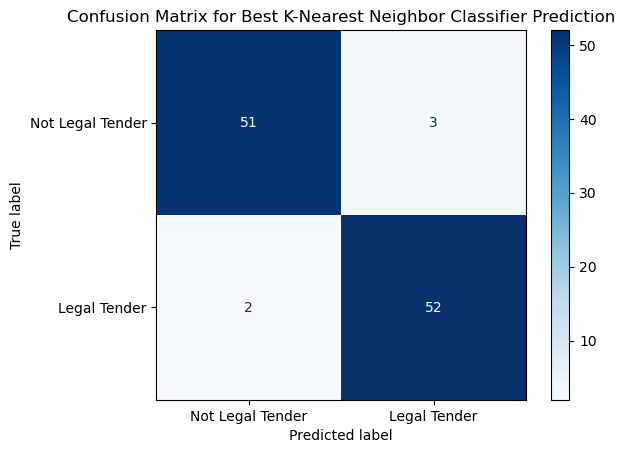

False Positive (FP): 3
False Negative (FN): 2

Decision Tree Classifier
DT Runtime Using Default DT Params: 0.00300 seconds
DT Accuracy Score Using Default DT Params: 86.111%
Bag Runtime Using Default Bag Params w/ Default DT Params: 1.98918 seconds
Bag Accuracy Score Using Default Bag Params w/ Default DT Params: 91.667%
Fitting 10 folds for each of 7680 candidates, totalling 76800 fits
Best DT Params According To GridSearchCV: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'max_leaf_nodes': 100, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
DT Runtime Using Best DT Params According To GridSearchCV: 14.72791 seconds
DT Accuracy Score Using Best DT Params According To GridSearchCV: 94.444%
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best DT Params According To RandomizedSearchCV: {'splitter': 'random', 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_leaf_nodes': None, 'max_features': 'log2', 'max_depth

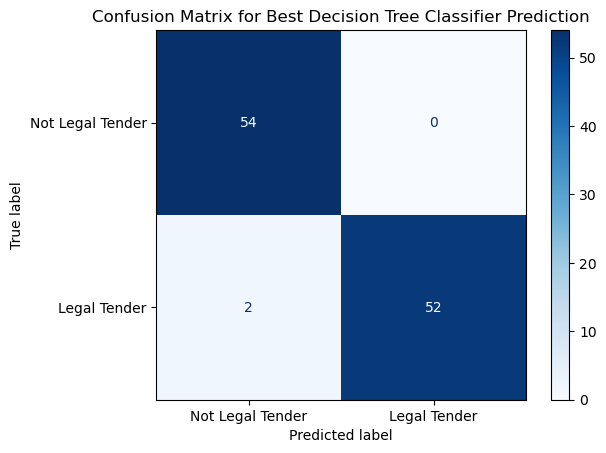

False Positive (FP): 0
False Negative (FN): 2


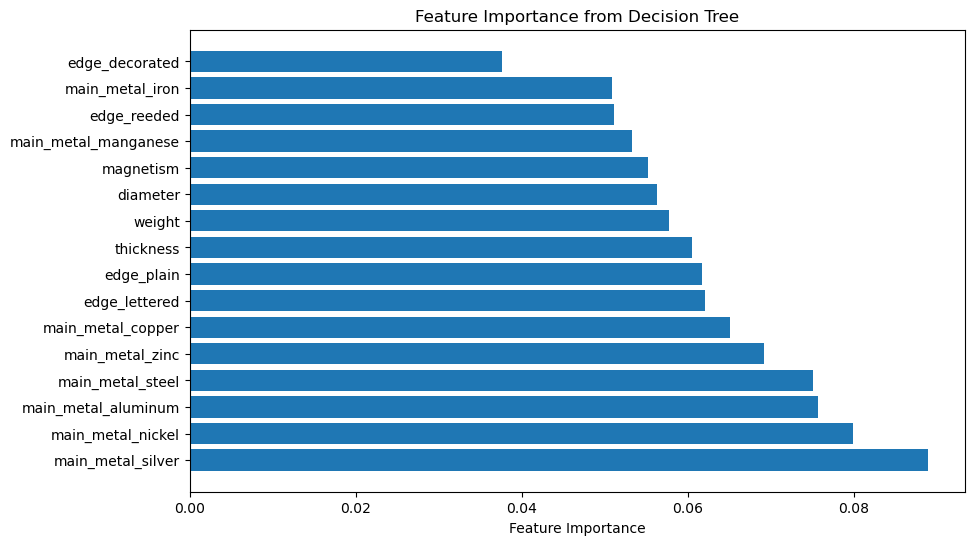

edge_decorated: 3.763%
main_metal_iron: 5.088%
edge_reeded: 5.114%
main_metal_manganese: 5.325%
magnetism: 5.517%
diameter: 5.631%
weight: 5.773%
thickness: 6.043%
edge_plain: 6.17%
edge_lettered: 6.208%
main_metal_copper: 6.506%
main_metal_zinc: 6.911%
main_metal_steel: 7.503%
main_metal_aluminum: 7.568%
main_metal_nickel: 7.991%
main_metal_silver: 8.888%

Random Forest Classifier
RF Runtime Using Default RF Params: 0.06175 seconds
RF Accuracy Score Using Default RF Params: 97.222%
Bag Runtime Using Default Bag Params w/ Default RF Params: 2.11494 seconds
Bag Accuracy Score Using Default Bag Params w/ Default RF Params: 94.444%
Fitting 10 folds for each of 4320 candidates, totalling 43200 fits
Best RF Params According To GridSearchCV: {'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
RF Runtime Using Best RF Params According To GridSearchCV: 457.57454 seco

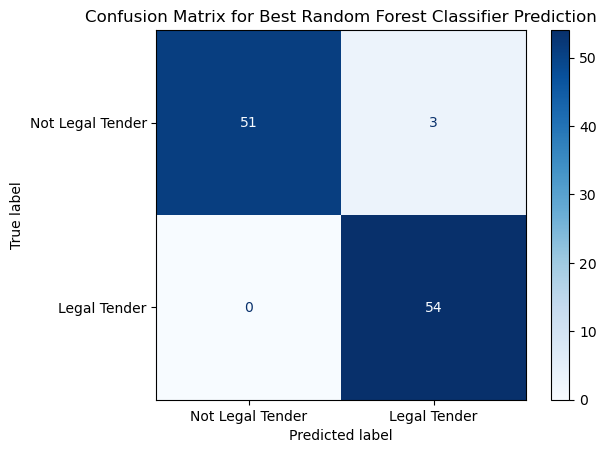

False Positive (FP): 3
False Negative (FN): 0


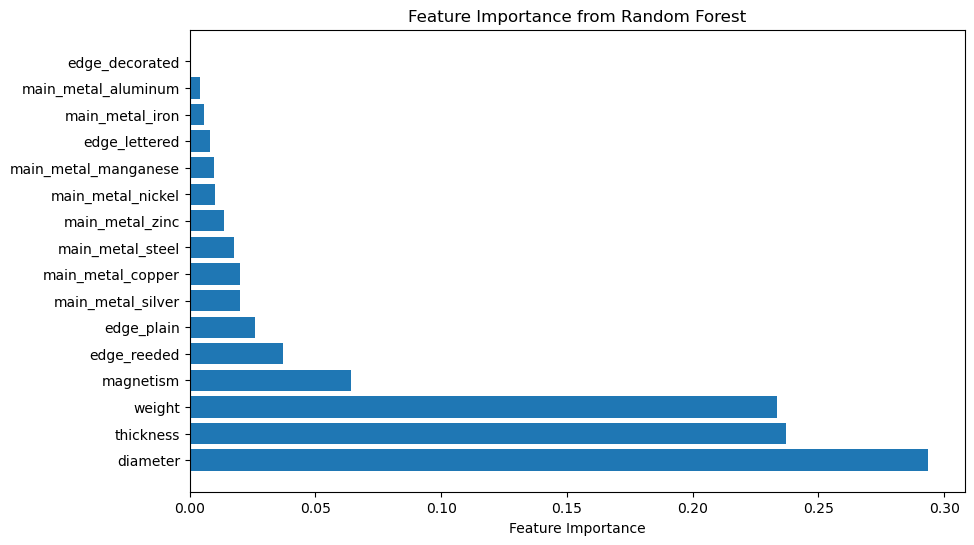

edge_decorated: 0.0%
main_metal_aluminum: 0.401%
main_metal_iron: 0.585%
edge_lettered: 0.801%
main_metal_manganese: 0.977%
main_metal_nickel: 1.007%
main_metal_zinc: 1.36%
main_metal_steel: 1.752%
main_metal_copper: 1.981%
main_metal_silver: 2.006%
edge_plain: 2.6%
edge_reeded: 3.727%
magnetism: 6.41%
weight: 23.358%
thickness: 23.688%
diameter: 29.346%

Perceptron Classifier
Perceptron Runtime Using Default Perceptron Params: 0.00100 seconds
Perceptron Accuracy Score Using Default Perceptron Params: 72.222%
Bag Runtime Using Default Bag Params w/ Default Perceptron Params: 1.91110 seconds
Bag Accuracy Score Using Default Bag Params w/ Default Perceptron Params: 73.148%
Fitting 10 folds for each of 57600 candidates, totalling 576000 fits
Best Perceptron Params According To GridSearchCV: {'alpha': 0.001, 'early_stopping': True, 'eta0': 1, 'max_iter': 500, 'n_iter_no_change': 25, 'penalty': None, 'tol': 1e-05, 'validation_fraction': 0.1}
Perceptron Runtime Using Best Perceptron Params A

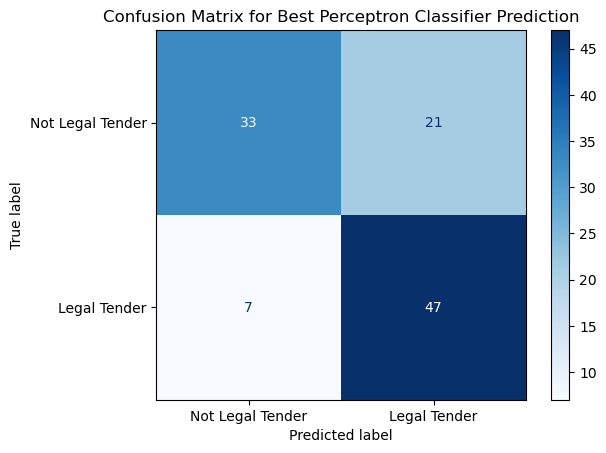

False Positive (FP): 21
False Negative (FN): 7

Logistic Regression Classifier
LR Runtime Using Default LR Params: 0.00200 seconds
LR Accuracy Score Using Default LR Params: 67.593%
Bag Runtime Using Default Bag Params w/ Default LR Params: 1.84968 seconds
Bag Accuracy Score Using Default Bag Params w/ Default LR Params: 69.444%
Fitting 10 folds for each of 5040 candidates, totalling 50400 fits
Best LR Params According To GridSearchCV: {'C': 0.01, 'class_weight': None, 'intercept_scaling': 1, 'max_iter': 100, 'solver': 'newton-cg', 'tol': 0.1, 'warm_start': True}
LR Runtime Using Best LR Params According To GridSearchCV: 11.94676 seconds
LR Accuracy Score Using Best LR Params According To GridSearchCV: 55.556%
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best LR Params According To RandomizedSearchCV: {'warm_start': False, 'tol': 0.1, 'solver': 'newton-cg', 'max_iter': 100, 'intercept_scaling': 10, 'class_weight': 'balanced', 'C': 50}
LR Runtime Using Best LR Params A

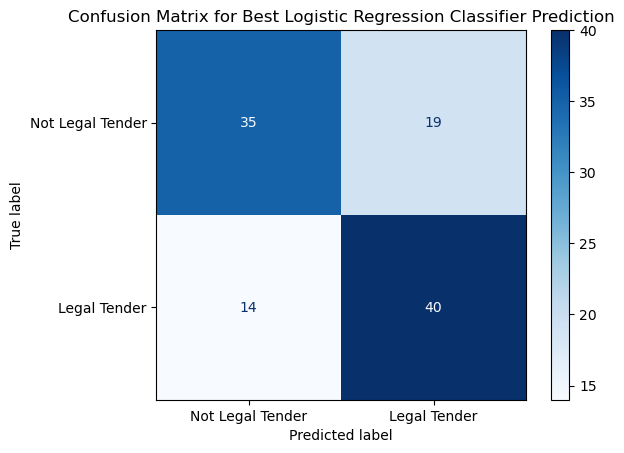

False Positive (FP): 19
False Negative (FN): 14


In [9]:
KNN_ROE_classifier()
DT_ROE_classifier()
RF_ROE_classifier()
Perceptron_ROE_classifier()
LR_ROE_classifier()